## 학교 전력 데이터를 이용하여 net load 선형 예측해보기 - 2. 단순선형회귀모델 찾기

### 목표: Day N의 net load data를 알 때 Day N+1의 net load를 예측하는 선형 회귀 모델을 만드는 것이 목표이다.


### 데이터 종류: PV 데이터, net load 데이터


### 데이터 가공: 일단 pv 데이터는 이용하지 않고, net load 데이터들만 쭉 모아서 단순선형회귀모델을 만들어본다.


### 프로세스
1. 데이터 가공
  - 전력사용량 데이터(net load) excel에서 신재생에너지동(RISE) 데이터만 쭉 뽑기
  - 신재생에너지동(E)도 고려
  - 반복문을 사용하여 엑셀에서 column을 쭉 뽑음
  - 셀이 '-'로 채워진 데이터는 누락시킴. 이 경우 일단 Day N, N+1 관계 성립 안 됨
  - 평일&비공휴일/주말|공휴일 구분하여 서로 다른 csv 파일에 저장(week/weekend): 주말 및 공휴일의 flag를 1로 설정한 2021 calendar excel 파일 제작하여 이용

2. 선형회귀모델 찾기
*   torch.linalg.pinv 이용하여 pseudo-inverse matrix(선형 변환 matrix) 구하기
*   sklearn의 LinearRegression 모듈을 이용하여 Linear Regression model 구하기
*   경사하강법을 이용하여 Linear Regression model 찾기
 - learning rate: 1e-6
 - epoch: 5000
 - train:test = 8:2


### 보완점
다중선형회귀모델을 만들어볼 수 있을 것. PV data, 외기온도, 비상전력데이터, 주말 여부(flag 등으로 처리) 등을 고려할 수 있음.
노이즈를 추가할 수 있음.
누락된 값을 고려하여 더 정확하게 측정할 수 있음.

==> 피드백 받은 부분:
1. 월요일부터 금요일까지의 주중 데이터만 이용해보기. calender file만 따로 만들어서 휴일에는 flag를 마크하여 data와 calender 비교해서 처리하기!
2. output이랑 y plot 해서 비교해보기! mse가 크게 나온 것은 rmse로 하면 60 정도, 전력 데이터양에 따라 달라지는 것이기 때문에 그리 정확하지 않음. 보통 평균적으로 얼만큼 전력을 쓰는지도 함께 기입하여 비교함! mse, mae, mape 등의 지표를 사용하는 것도 좋음. mape의 경우 평균치에 비해(%) 얼마나 오차가 발생했는지를 보여주기 때문에 비교하기 좋음.
3. 누락된 데이터의 경우에는 interpollation 실행. 대표적인 방법으로는 (1)전날과 다음날의 평균을 취한다. (2)전날 데이터를 그대로 가져온다. (3)전날과 가장 값이 비슷한 이전 데이터를 찾아서 그 다음날의 데이터를 취한다...


==> 보완된 부분
1. 많은 데이터를 가공하기 위해 format을 이용하여 file_path를 지정하였다.
2. Emergency data를 포함하였다.
3. 가공한 데이터를 csv 형식으로 저장해두었다.




** 페널티 항을 더해볼 수 있을 듯!
** validation set을 추가할 수 있을 듯!


In [1]:
# load refined data

# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import torch
import os

df = pd.read_csv('/content/drive/MyDrive/week_2021_netload.csv', index_col=0)

X = df.iloc[0:236,:]
Y = df.iloc[1:237,:]

Mounted at /content/drive


In [2]:
df.shape

(237, 24)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
210104,879.6,906.7,902.6,866.7,821.9,869.8,853.7,893.9,1063.9,1099.7,...,1103.2,1099.1,1105.6,1100.7,1043.8,1016.0,975.6,979.7,982.6,933.4
210105,925.6,936.7,882.7,894.6,864.2,859.1,853.7,891.3,957.4,1084.6,...,1159.4,1173.3,1168.5,1149.9,1105.5,976.7,978.8,989.3,965.6,968.6
210106,941.6,938.5,908.3,922.8,889.1,909.2,890.2,958.8,1094.0,1174.3,...,1108.5,1095.2,1121.3,1150.4,1040.5,1043.8,1018.8,1017.6,978.0,958.3
210107,959.1,993.6,928.9,974.8,1028.6,985.0,971.7,1021.1,1077.4,1265.7,...,1350.3,1351.6,1358.4,1349.0,1279.1,1213.7,1264.2,1229.0,1223.8,1205.3
210108,1190.3,1182.8,1160.8,1122.6,1099.7,1116.8,1140.9,1152.3,1314.6,1387.3,...,1342.3,1312.9,1317.2,1345.6,1326.0,1207.8,1231.6,1258.3,1264.5,1202.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211224,782.2,793.3,787.0,756.0,771.0,761.1,770.9,812.5,886.9,995.8,...,927.1,898.5,918.8,941.3,836.4,856.5,783.0,807.5,819.0,787.2
211227,862.1,868.6,836.0,849.5,886.9,861.9,888.2,896.7,1085.6,1175.6,...,1127.3,1143.3,1149.3,1139.0,1111.6,1011.1,1026.3,946.0,938.4,922.8
211228,885.6,890.9,859.7,875.7,868.3,853.8,850.5,868.5,958.5,1124.9,...,1134.4,1102.5,1071.2,1091.4,997.6,928.1,933.0,862.6,902.8,896.1
211229,847.5,877.3,824.7,813.5,836.8,774.4,809.9,853.0,976.3,1021.6,...,959.4,976.4,998.9,956.7,893.3,871.3,902.9,878.8,910.0,869.2


In [4]:
from torch import linalg as LA
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.9, shuffle=False)

# LA expects tensor, so change dataframe to numpy to tensor
# In this process, I changed numpy type from object to float64 because 'from_numpy' method cannot convert object type
# --> change float64 to float32, because of an error https://discuss.pytorch.org/t/runtimeerror-mat1-and-mat2-must-have-the-same-dtype/166759/4
x_train_tnsr = torch.FloatTensor(x_train.values)
y_train_tnsr = torch.FloatTensor(y_train.values)

In [5]:
torch.FloatTensor(x_train.values)

tensor([[ 879.6000,  906.7000,  902.6000,  ...,  979.7000,  982.6000,
          933.4000],
        [ 925.6000,  936.7000,  882.7000,  ...,  989.3000,  965.6000,
          968.6000],
        [ 941.6000,  938.5000,  908.3000,  ..., 1017.6000,  978.0000,
          958.3000],
        ...,
        [ 708.1000,  706.2000,  683.0000,  ...,  704.4000,  720.9000,
          693.7000],
        [ 703.1000,  686.6000,  650.6000,  ...,  719.9000,  724.6000,
          743.0000],
        [ 680.2000,  690.2000,  673.2000,  ...,  789.1000,  750.3000,
          770.3000]])

In [6]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 21.0 MB/s eta 0:00:00


In [7]:
# set model,loss function, optimization function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score
from torchmetrics import MeanAbsolutePercentageError


# Linear Regression model
model = nn.Linear(24,24)

# MSE as loss function
loss_func = F.mse_loss

# MAE
mae = F.l1_loss

# MAPE as loss function
# 참고 사이트: https://torchmetrics.readthedocs.io/en/stable/regression/mean_absolute_percentage_error.html
mape = MeanAbsolutePercentageError()

# SGD as optimization function
# 여러가지 테스트해본 결과 1e-6이 가장 작은 loss를 산출
optimizer = optim.SGD(model.parameters(),lr=1e-6)

# the number of learning times
epochs = 500

# loss(rmse) 저장할 array 생성
loss_arr = []

In [8]:
# model training
for epoch in range(epochs):

  model.train()
  
  # 이전 학습 기울기를 지우고 최적화 함수를 초기화
  optimizer.zero_grad()
  
  output = model(x_train_tnsr)
  loss = loss_func(output, y_train_tnsr)

  # 손실에 대한 기울기 구하기
  loss.backward()

  # update model parameters
  optimizer.step()

  # loss-rmse 저장

  loss_arr.append((loss.detach().numpy()**0.5))

  if epoch%10 == 0:
    print('Epoch {:4d}/{} Loss: {:.6f}'.format(epoch, epochs, loss.item()**0.5))

Epoch    0/500 Loss: 1075.106448
Epoch   10/500 Loss: 78.809777
Epoch   20/500 Loss: 76.393736
Epoch   30/500 Loss: 75.788811
Epoch   40/500 Loss: 75.208233
Epoch   50/500 Loss: 74.650713
Epoch   60/500 Loss: 74.115392
Epoch   70/500 Loss: 73.601439
Epoch   80/500 Loss: 73.108064
Epoch   90/500 Loss: 72.634476
Epoch  100/500 Loss: 72.179931
Epoch  110/500 Loss: 71.743698
Epoch  120/500 Loss: 71.325053
Epoch  130/500 Loss: 70.923309
Epoch  140/500 Loss: 70.537816
Epoch  150/500 Loss: 70.167907
Epoch  160/500 Loss: 69.812983
Epoch  170/500 Loss: 69.472415
Epoch  180/500 Loss: 69.145651
Epoch  190/500 Loss: 68.832099
Epoch  200/500 Loss: 68.531243
Epoch  210/500 Loss: 68.242534
Epoch  220/500 Loss: 67.965492
Epoch  230/500 Loss: 67.699611
Epoch  240/500 Loss: 67.444443
Epoch  250/500 Loss: 67.199523
Epoch  260/500 Loss: 66.964426
Epoch  270/500 Loss: 66.738730
Epoch  280/500 Loss: 66.522039
Epoch  290/500 Loss: 66.313962
Epoch  300/500 Loss: 66.114141
Epoch  310/500 Loss: 65.922214
Epoch 

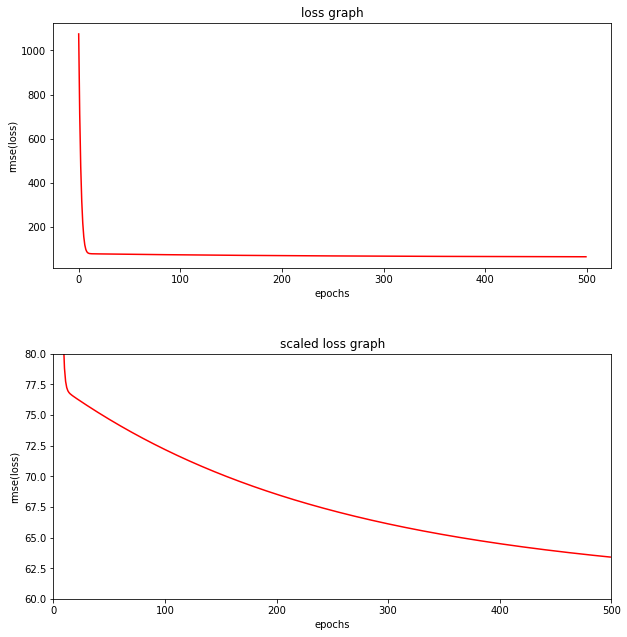

In [9]:
import matplotlib.pyplot as plt

x_loss = np.reshape([i for i in range(epochs)], newshape=[epochs, 1])
train_loss_data = np.reshape(loss_arr, newshape=[epochs,1])

fig = plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.title('loss graph')
plt.plot(x_loss,train_loss_data, 'r')
plt.xlabel('epochs')
plt.ylabel('rmse(loss)')

plt.subplot(212)
plt.title('scaled loss graph')
plt.plot(x_loss,train_loss_data, 'r')
plt.axis([0,epochs, 60, 80])
plt.xlabel('epochs')
plt.ylabel('rmse(loss)')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
 

plt.show()

In [10]:
# evaluation
model.eval()

x_test_tnsr = torch.FloatTensor(x_test.values)
y_test_tnsr = torch.FloatTensor(y_test.values)

output = model(x_test_tnsr)
loss = loss_func(output, y_test_tnsr)
loss_mae = mae(output, y_test_tnsr)
loss_mape = mape(output, y_test_tnsr)

print('rmse:',loss**(0.5))
print('mae: ', loss_mae)
print('mape: ', loss_mape)

print('mean value: ', torch.mean(x_test_tnsr))

r2 = r2_score(y_test_tnsr.detach().numpy(), output.detach().numpy())
print('\nLinearRegression model r2 score:', r2)

rmse: tensor(72.2471, grad_fn=<PowBackward0>)
mae:  tensor(54.1574, grad_fn=<MeanBackward0>)
mape:  tensor(0.0615, grad_fn=<SqueezeBackward0>)
mean value:  tensor(851.2834)

LinearRegression model r2 score: 0.03799957868163319


In [12]:
y_test.iloc[[15]]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
211220,808.3,784.9,804.3,792.6,805.9,798.3,796.0,838.5,922.5,1068.7,...,952.3,941.0,889.5,929.2,890.7,814.1,830.3,817.8,815.3,888.9


In [13]:
y_test.iloc[[15]]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
211220,808.3,784.9,804.3,792.6,805.9,798.3,796.0,838.5,922.5,1068.7,...,952.3,941.0,889.5,929.2,890.7,814.1,830.3,817.8,815.3,888.9


In [14]:
import matplotlib.pyplot as plt

def plot(i, length):
  fig = plt.figure(figsize=(10, 5))
  plt.title('Actual and forecast net-load for a week', fontsize = 18)
  plt.xlabel('Time (h)', fontsize = 15)
  plt.ylabel('Net-load', fontsize = 15)
  plt.plot(y_test_tnsr.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
  plt.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
  plt.legend(loc='lower right', fontsize = 13)
  # plt.plot(y_train_tnsr.detach().numpy(), c='red')
  # print(x_train_tnsr.detach().numpy()[:,0])

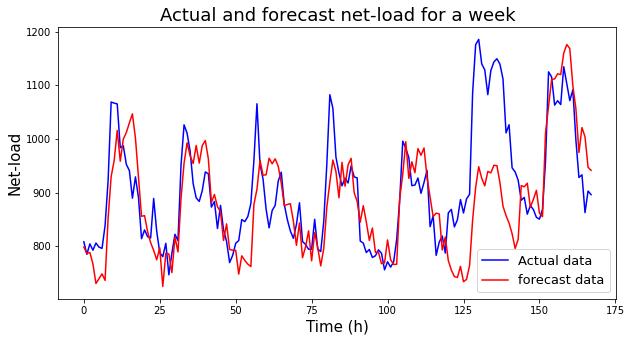

In [15]:
plot(15, 7)

In [16]:
# sklearn의 LinearRegression 모듈 사용
# 모델 평가를 위해 r2 score 사용

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

clf = LinearRegression()
clf.fit(x_train, y_train)

sk_output = clf.predict(x_test)
sk_r2 = r2_score(y_test, sk_output)
print('sklearn LinearRegression model r2 score:', sk_r2)

# 출력해보면 DIY와 결과가 같음.

sklearn LinearRegression model r2 score: 0.12262618155912713
